<a href="https://colab.research.google.com/github/fyemane/TensorFlow-ZTM-/blob/main/11_tensorflow_exam_skills_checklist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building and training neural network models using TensorFlow 2.x

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.12.0


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-07-29 20:52:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-29 20:52:24 (69.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [ ]:
# Preprocesss
# ...normalize (get between 0 & 1)

In [ ]:
# Build model

# Compile model

# Train model..

In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

In [ ]:
(test_data, train_data, validation_data), ds_info = tfds.load("sci_tail",
                                             split=['test', 'train', 'validation'],
                                             shuffle_files=True,
                                             with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'hypothesis': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'premise': Text(shape=(), dtype=string),
})

In [ ]:
train_data

<_PrefetchDataset element_spec={'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['entails', 'neutral']

In [ ]:
train_df = tfds.as_dataframe(train_data)
validation_df = tfds.as_dataframe(validation_data)
test_df = tfds.as_dataframe(test_data)
train_df.head()

,hypothesis,label,premise
0,b'Thermoregulation is the process when animals...,0,b'Thermoregulation is a survival trick that he...
1,b'Precipitation and runoff in the water cycle ...,1,b'Hydrologic Cycle: Precipitation = Evapotrans...
2,b'Tides is the term for when the water of the ...,0,b'Tides are periodic rises and falls of large ...
3,b'A cell wall is not present in animal cells.',1,b'Lignins are built into the structure of the ...
4,"b'Plasma completes the list: solid, liquid, gas.'",0,"b'Matter can exist as a solid , a liquid , a g..."


In [ ]:
train_hypotheses = train_df["hypothesis"]
train_labels = train_df["label"]
train_premises = train_df["premise"]

val_hypotheses = validation_df["hypothesis"]
val_labels = validation_df["label"]
val_premises = validation_df["premise"]

test_hypotheses = test_df["hypothesis"]
test_labels = test_df["label"]
test_premises = test_df["premise"]

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Create a model using the Sequential API
hypothesis_inputs = layers.Input(shape=[], dtype="string", name="hypothesis_inputs")
hypothesis_embeddings = tf_hub_embedding_layer(hypothesis_inputs)
hypothesis_outputs = layers.Dense(64, activation="relu")(hypothesis_embeddings)
hypothesis_model = tf.keras.Model(inputs=hypothesis_inputs,
                                  outputs=hypothesis_outputs)

premise_inputs = layers.Input(shape=[], dtype="string", name="premise_inputs")
premise_embeddings = tf_hub_embedding_layer(premise_inputs)
premise_outputs = layers.Dense(64, activation="relu")(premise_embeddings)
premise_model = tf.keras.Model(inputs=premise_inputs,
                                  outputs=premise_outputs)

combined_embeddings = layers.Concatenate(name="text_inputs")([hypothesis_model.output,
                                                              premise_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
output_layer = layers.Dense(1, activation="sigmoid", name="output_layer")(z)
model_1 = tf.keras.Model(inputs=[hypothesis_model.input,
                                 premise_model.input],
                         outputs=output_layer,
                         name="model_1")

# Compile
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 hypothesis_inputs (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 premise_inputs (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['hypothesis_inputs[0][0]',      
 rasLayer)                                                        'premise_inputs[0][0]']         
                                                                                                  
 dense_17 (Dense)               (None, 64)           32832       ['universal_sentence_encode

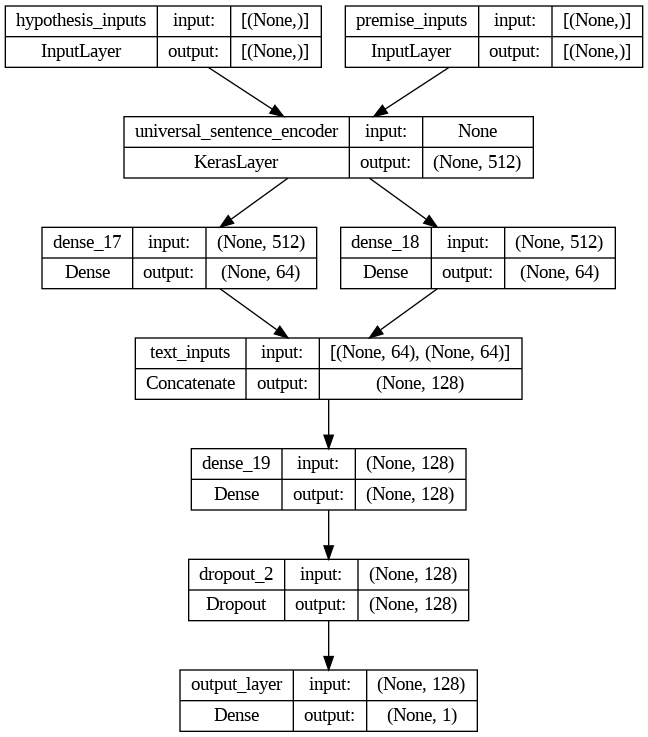

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True)

In [ ]:
train_pipedata = tf.data.Dataset.from_tensor_slices((train_hypotheses,
                                                    train_premises))
train_pipelabels = tf.data.Dataset.from_tensor_slices((train_labels))
train_dataset = tf.data.Dataset.zip((train_pipedata, train_pipelabels))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pipedata = tf.data.Dataset.from_tensor_slices((val_hypotheses,
                                                    val_premises))
val_pipelabels = tf.data.Dataset.from_tensor_slices((val_labels))
val_dataset = tf.data.Dataset.zip((val_pipedata, val_pipelabels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
model_1.fit(train_dataset,
            validation_data=val_dataset)

TypeError: ignored